# Two Moons: Tackling Bimodal Posteriors

_Authors: Lars Kühmichel, Marvin Schmitt, Valentin Pratz, Stefan T. Radev_

In [1]:
import sys
sys.path.append("../")

In [ ]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import bayesflow as bf

## Simulator<a class="anchor" id="simulator"></a>

This example will demonstrate amortized estimation of a somewhat strange Bayesian model, whose posterior evaluated at the origin $x = (0, 0)$ of the "data" will resemble two crescent moons. The forward process is a noisy non-linear transformation on a 2D plane:

$$
\begin{align}
x_1 &= -|\theta_1 + \theta_2|/\sqrt{2} + r \cos(\alpha) + 0.25\\
x_2 &= (-\theta_1 + \theta_2)/\sqrt{2} + r\sin{\alpha}
\end{align}
$$

with $x = (x_1, x_2)$ playing the role of "observables" (data to be learned from), $\alpha \sim \text{Uniform}(-\pi/2, \pi/2)$, and $r \sim \text{Normal}(0.1, 0.01)$ being latent variables creating noise in the data, and $\theta = (\theta_1, \theta_2)$ being the parameters that we will later seek to infer from new $x$. We set their priors to

$$
\begin{align}
\theta_1, \theta_2 \sim \text{Uniform}(-1, 1).
\end{align}
$$

This model is typically used for benchmarking simulation-based inference (SBI) methods (see https://arxiv.org/pdf/2101.04653) and any method for amortized Bayesian inference should be capable of recovering the two moons posterior *without* using a gazillion of simulations. Note, that this is a considerably harder task than modeling the common unconditional two moons data set used often in the context of normalizing flows. However, free-form models (e.g., flow matching, diffusion) will tend to outperform normalizing flows on multimodal data sets.

BayesFlow offers many ways to define your data generating process. Here, we use sequential functions to build a simulator object for online training. Within this composite simulator, each function has access to the outputs of the previous functions. This effectively allows you to define any generative graph.

In [3]:
def theta_prior():
    theta = np.random.uniform(-1, 1, 2)
    return dict(theta=theta)

def forward_model(theta):
    alpha = np.random.uniform(-np.pi / 2, np.pi / 2)
    r = np.random.normal(0.1, 0.01)
    x1 = -np.abs(theta[0] + theta[1]) / np.sqrt(2) + r * np.cos(alpha) + 0.25
    x2 = (-theta[0] + theta[1]) / np.sqrt(2) + r * np.sin(alpha)
    return dict(x=np.array([x1, x2]))

Within the composite simulator, every simulator has access to the outputs of the previous simulators in the list. For example, the last simulator `forward_model` has access to the outputs of the three other simulators.

In [4]:
simulator = bf.make_simulator([theta_prior, forward_model])

Let's generate some data to see what the simulator does:

In [5]:
# generate 3 random draws from the joint distribution p(r, alpha, theta, x)
sample_data = simulator.sample(3)

In [6]:
print("Type of sample_data:\n\t", type(sample_data))
print("Keys of sample_data:\n\t", sample_data.keys())
print("Types of sample_data values:\n\t", {k: type(v) for k, v in sample_data.items()})
print("Shapes of sample_data values:\n\t", {k: v.shape for k, v in sample_data.items()})

Type of sample_data:
	 <class 'dict'>
Keys of sample_data:
	 dict_keys(['theta', 'x'])
Types of sample_data values:
	 {'theta': <class 'numpy.ndarray'>, 'x': <class 'numpy.ndarray'>}
Shapes of sample_data values:
	 {'theta': (3, 2), 'x': (3, 2)}


BayesFlow also provides this simulator and a collection of others in the `bayesflow.benchmarks` module.

## Adapter

The next step is to tell BayesFlow how to deal with all the simulated variables. You may also think of this as informing BayesFlow about the data flow, i.e., which variables go into which network and what transformations needs to be performed prior to passing the simulator outputs into the networks. This is done via an adapter layer, which is implemented as a sequence of fixed, pseudo-invertible data transforms.

Below, we define the data adapter by specifying the input and output keys and the transformations to be applied. This allows us full control over the data flow.

In [7]:
adapter = (
    bf.adapters.Adapter()
    
    # convert any non-arrays to numpy arrays
    .to_array()
    
    # convert from numpy's default float64 to deep learning friendly float32
    .convert_dtype("float64", "float32")
    
    # standardize target variables to zero mean and unit variance 
    .standardize(exclude="theta")
    
    # rename the variables to match the required approximator inputs
    .rename("theta", "inference_variables")
    .rename("x", "inference_conditions")
)
adapter

Adapter([0: ToArray -> 1: ConvertDType -> 2: Standardize(exclude=['theta']) -> 3: Rename('theta' -> 'inference_variables') -> 4: Rename('x' -> 'inference_conditions')])

## Dataset

For this example, we will sample our training data ahead of time and use offline training with a very small number of epochs. In actual applications, you usually want to train much longer in order to max our performance.

In [24]:
num_training_batches = 512
num_validation_sets = 300
batch_size = 64
epochs = 50

In [25]:
training_data = simulator.sample(num_training_batches * batch_size)
validation_data = simulator.sample(num_validation_sets)

## Training a neural network to approximate all posteriors

The next step is to set up the neural network that will approximate the posterior $p(\theta\,|\,x)$.

We choose **Flow Matching** [1, 2] as the backbone architecture for this example, as it can deal well with the multimodal nature of the posteriors that some observables imply.

* [1] Lipman, Y., Chen, R. T., Ben-Hamu, H., Nickel, M., & Le, M. Flow Matching for Generative Modeling. In *The Eleventh International Conference on Learning Representations*.

* [2] Wildberger, J. B., Dax, M., Buchholz, S., Green, S. R., Macke, J. H., & Schölkopf, B. Flow Matching for Scalable Simulation-Based Inference. In *Thirty-seventh Conference on Neural Information Processing Systems*.

In [10]:
flow_matching = bf.networks.FlowMatching(
    subnet="mlp", 
    subnet_kwargs={"dropout": 0.0, "widths": (256,)*6} # override default dropout = 0.05 and widths = (256,)*5
)

This inference network is just a general Flow Matching backbone, not yet adapted to the specific inference task at hand (i.e., posterior appproximation). To achieve this adaptation, we combine the network with our data adapter, which together form an `approximator`. In this case, we need a `ContinuousApproximator` since the target we want to approximate is the posterior of the *continuous* parameter vector $\theta$.

### Basic Workflow
We can hide many of the traditional deep learning steps (e.g., specifying a learning rate and an optimizer) within a `Workflow` object. This object just wraps everything together and includes some nice utility functions for training and *in silico* validation.

In [11]:
flow_matching_workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    inference_network=flow_matching,
)

### Training

We are ready to train our deep posterior approximator on the two moons example. We use the utility function `fit_offline`, which wraps the approximator's super flexible `fit` method.

In [12]:
history = flow_matching_workflow.fit_offline(
    training_data, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_data=validation_data
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.9825 - loss/inference_loss: 0.9825 - val_loss: 0.5196 - val_loss/inference_loss: 0.5196
Epoch 2/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.5825 - loss/inference_loss: 0.5825 - val_loss: 0.3154 - val_loss/inference_loss: 0.3154
Epoch 3/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.4648 - loss/inference_loss: 0.4648 - val_loss: 0.3559 - val_loss/inference_loss: 0.3559
Epoch 4/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.4057 - loss/inference_loss: 0.4057 - val_loss: 0.2968 - val_loss/inference_loss: 0.2968
Epoch 5/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.3846 - loss/inference_loss: 0.3846 - val_loss: 0.5848 - val_loss/inference_loss: 0.5848
Epoch 6/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.3763 - loss/inference_loss: 0.3763 - val_loss: 0.2406 - val_loss/inference_loss: 0.2406
Epoch 7/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.3722 - loss/inference_loss: 0.3722 - v

## Swapping Inference Networks <a class="anchor" id="swapping"></a>

Using BayesFlow, it is easy to switch to a different backbone architecture for the inference network. For instance, the code below demonstrates the use of a **Consistency Model**, which can allow for faster sampling during inference.

### Consistency Models: Background

Consistency Models (CM; [1]) leverage the nice properties of score-based diffusion to enable few-step sampling. Score-based diffusion initially relied on a stochastic differential equation (SDE) for sampling, but there is also a ordinary (non-stochastic) differential equation (ODE)that has the same _marginal_ distribution at each time step $t$ [2]. This means that even though SDE and ODE produce different paths from the noise distribution to the target distribution, the resulting distributions when looking at many paths at time $t$ is the same. The ODE is also called Probability Flow ODE.

CMs leverage the fact that there is no randomness in the ODE formulation. That means, if you start at a certain point in the latent space, you will always take the same path and end up at the same point in the target $\theta$-space. The same is true for every point on the path: if you integrate to get to time $t=0$, you will end up at the same point as well. In short: for each path, there is exactly one corresponding point in latent space (at $t=T$) and one corresponding point in data space (at $t=0$). 

The goal of CMs is the following: each point at a time point $t$ belongs to exactly one path, and we want to predict where this path will end up at $t=0$. The function that does this is called the _consistency function_ $f$. If we have the correct function for all $t\in(0,T]$, we can just sample from the latent distribution ($t=T$) and use $f$ to directly map to the corresponding point at $t=0$, which is in the target distribution. So for sampling from the target distribution, we avoid any integration and only need one evaluation of the consistency function. In practice, the one-step sampling does not work very well. Instead, we leverage a multi-step sampling method where we call $f$ multiple times. Please check out the [1] for more background on this sampling procedure.

When reading the above, you might wonder why we also learn the mapping to $t=0$ of all intermediate time steps $t\in[0, T]$, and not only for $t=T$. The main answer is that for efficient training, we do not want to actually compute the two associated points explicitly. Doing so would require to do a precise integration at training time, which is often not feasible as it is too computationally costly. Learning all time steps opens up the possibility for a different training approach where we can avoid this. The details of this become a bit more complicated, and we advise you to take a look at [1] if you are interested in a more thorough and mathematical discussion. Below, we will give a rough description of the underlying concepts.


**Training** First, we know that at $t=0$, it holds that $f(\theta,t=0)=\theta$, as $\theta$ is part of the path that ends at $\theta$. This _boundary condition_ serves as an "anchor" for our training, this is the information that the network knows at the start of the training procedure (we encode it with a time-dependent skip-connection, so the network is forced to be the identity function at $t=0$). For training, we now somehow have to propagate this information to the rest of the part. The basic idea for this is simple. We just take a point $\theta_1$ closer to the data distribution (smaller time $t_1$) and integrate for a small time step $dt$ to a point $\theta_2$ on the same path that is closer to the latent distribution (larger time $t_2=t_1+dt$). As we know that for $t=0$ our network provides the correct output for our path, we want to propagate the information from smaller times to larger times. Our training goal is to move the output of $f(\theta_2, t=t_2)$ towards the output of $f(\theta_1, t=t_1)$. How to choose $\theta_1$, $t_1$ and $dt$ is an empirical question, see the [1] for some thoughts on what works well.

**Distilling inference** In the case of _distillation_, we start with a trained score-based diffusion model. We can use it to integrate the Probability Flow ODE to get from $\theta_1$ to $\theta_2$. If we do not have such a model, it seems as if we were stuck. We do not know which points lie on the same path, so we do not know which outputs to make similar. Fortunately, it turns out that there is an _unbiased approximator_ that, if averaged over many samples (check out the paper for the exact description), will also give us the correct score. If we use this approximator instead of the score model, and use only a single Euler step to move along the path, we get an algorithm similar to the one described for distillation. It is called Consistency Training (CT) and allows us to train a consistency model using only _samples_ from the data distribution. The algorithm for this was improved a lot in [3], and we have incorporated those improvements into our implementation.

**Improving consistency training** We have made several approximations to get to a standalone *consistency training* algorithm. As a consequence, the introduced hyperparameters and their choice unfortunately becomes somewhat unintuitive. We have to rely on empirical observations and heuristics to see what works. This was done in [4], we encourage you to use the values provided there as starting points. If you happen to find hyperparameters that work significantly better, please let us know (e.g., by opening an issue or sending an email). This will help others to find the correct region in the hyperparameter space.

[1] Song, Y., Dhariwal, P., Chen, M., & Sutskever, I. (2023). Consistency Models. _arXiv preprint_. [https://doi.org/10.48550/arXiv.2303.01469](https://doi.org/10.48550/arXiv.2303.01469)

[2] Song, Y., Sohl-Dickstein, J., Kingma, D. P., Kumar, A., Ermon, S., & Poole, B. (2021). Score-Based Generative Modeling through Stochastic Differential Equations. In _International Conference on Learning Representations_. [https://openreview.net/forum?id=PxTIG12RRHS](https://openreview.net/forum?id=PxTIG12RRHS)

[3] Song, Y., & Dhariwal, P. (2023). Improved Techniques for Training Consistency Models. _arXiv preprint_. [https://doi.org/10.48550/arXiv.2310.14189](https://doi.org/10.48550/arXiv.2310.14189)

[4] Schmitt, M., Pratz, V., Köthe, U., Bürkner, P.-C., & Radev, S. T. (2024). Consistency Models for Scalable and Fast Simulation-Based Inference. _arXiv preprint_. [https://doi.org/10.48550/arXiv.2312.05440](https://doi.org/10.48550/arXiv.2312.05440)

### Consistency Models: Specification

We can now go ahead and define our new inference network backbone. Apart from the usual parameters like learning rate and batch size, CMs come with a number of different hyperparameters. Unfortunately, they can heavily interact, so they can be hard to tune. The main hyperparameters are:

- Maximum time `max_time`: This also serves as the standard deviation of the latent distribution. You can experiment with this, values from 10-200 seem to work well. In any case, it should be larger than the standard deviation of the target distribution.
- Minimum/maximum number of discretization steps during training `s0`/`s1`: The effect of those is hard to grasp. 10 works well for `s0`. Intuitively, increasing `s1` along with the number of epochs should lead to better result, but in practice we sometimes observe a breakdown for high values of `s1`. This seems to be problem-dependent, so just try it out.
- `sigma2` modifies the time-dependency of the skip connection. Its effect on the training is unclear, we recommend leaving it at 1.0 or setting it to the approximate variance of the target distribution.
- Smallest time value `eps` ($t=\epsilon$ is used instead of $t=0$ for numerical reasons): No large effect in our experiments, as long as it is kept small enough. Probably not worth tuning.

You may find that different hyperparameter values work better for your tasks.

A short note on dropout: in our experiments, dropout usually lead to worse performance, so generally we recommend setting the droput rate to $0.0$. Consistency training takes advantage of a noisy estimator of the score, so probably the training is already sufficiently noisy and extra dropout for regularization is not necessary.

In [13]:
# Compute the empirical variance of the draws from the prior θ ~ p(θ)
consistency_model = bf.networks.ConsistencyModel(
    subnet="mlp",
    subnet_kwargs={"dropout": 0.0, "widths": (256,)*6},
    total_steps=num_training_batches*epochs,
    max_time=10, # this probably needs to be tuned for a novel application
    sigma2=1.0,  # the data adapter standardizes our parameters, so set to 1.0
)

# Workflow for consistency model
consistency_model_workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    inference_network=consistency_model,
)

### Consistency Training

In [14]:
history = consistency_model_workflow.fit_offline(
    training_data, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_data=validation_data
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.3800 - loss/inference_loss: 0.3800 - val_loss: 0.3108 - val_loss/inference_loss: 0.3108
Epoch 2/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.2986 - loss/inference_loss: 0.2986 - val_loss: 0.3360 - val_loss/inference_loss: 0.3360
Epoch 3/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.2895 - loss/inference_loss: 0.2895 - val_loss: 0.2638 - val_loss/inference_loss: 0.2638
Epoch 4/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.2793 - loss/inference_loss: 0.2793 - val_loss: 0.3517 - val_loss/inference_loss: 0.3517
Epoch 5/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.2657 - loss/inference_loss: 0.2657 - val_loss: 0.2884 - val_loss/inference_loss: 0.2884
Epoch 6/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.2632 - loss/inference_loss: 0.2632 - val_loss: 0.3073 - val_loss/inference_loss: 0.3073
Epoch 7/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.2626 - loss/inference_loss: 0.2626 

## Good 'ol Coupling Flows

Of course, BayesFlow also supports established coupling flow models with a variety of parameters, including the timeless *affine* and *spline* flows.

In [23]:
affine_flow = bf.networks.CouplingFlow(subnet="mlp")

affine_flow_workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    inference_network=affine_flow,
)

In [15]:
spline_flow = bf.networks.CouplingFlow(subnet="mlp", transform="spline", depth=4)

spline_flow_workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    inference_network=spline_flow,
)

### Coupling Flow Training

First, we train the classic coupling flow:

In [26]:
history = affine_flow_workflow.fit_offline(
    training_data,
    epochs=30,
    batch_size=batch_size,
    validation_data=validation_data
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/30
512/512 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - loss: 0.2290 - loss/inference_loss: 0.2290 - val_loss: -0.8323 - val_loss/inference_loss: -0.8323
Epoch 2/30
512/512 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - loss: -1.5712 - loss/inference_loss: -1.5712 - val_loss: -2.0434 - val_loss/inference_loss: -2.0434
Epoch 3/30
512/512 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - loss: -2.2692 - loss/inference_loss: -2.2692 - val_loss: -2.3565 - val_loss/inference_loss: -2.3565
Epoch 4/30
512/512 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - loss: -2.3867 - loss/inference_loss: -2.3867 - val_loss: -2.3417 - val_loss/inference_loss: -2.3417
Epoch 5/30
512/512 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - loss: -2.5808 - loss/inference_loss: -2.5808 - val_loss: -2.5765 - val_loss/inference_loss: -2.5765
Epoch 6/30
512/512 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - loss: -2.6302 - loss/inference_loss: -2.6302 - val_loss: -2.5085 - val_loss/inference_loss: -2.5085
Epoch 7/30
512/512 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - loss: -2.7

Next, we train a spline flow for fewer epochs. Spline flows will generally outperform affine flows on multi-modal, low-dimensional problems.

In [19]:
history = spline_flow_workflow.fit_offline(
    training_data,
    epochs=30,
    batch_size=batch_size,
    validation_data=validation_data
)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - loss: 0.2557 - loss/inference_loss: 0.2557 - val_loss: -1.1560 - val_loss/inference_loss: -1.1560
Epoch 2/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - loss: -1.7267 - loss/inference_loss: -1.7267 - val_loss: -1.9166 - val_loss/inference_loss: -1.9166
Epoch 3/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - loss: -2.2900 - loss/inference_loss: -2.2900 - val_loss: -2.1307 - val_loss/inference_loss: -2.1307
Epoch 4/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 22s 42ms/step - loss: -2.5632 - loss/inference_loss: -2.5632 - val_loss: -2.4289 - val_loss/inference_loss: -2.4289
Epoch 5/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - loss: -2.7059 - loss/inference_loss: -2.7059 - val_loss: -2.8752 - val_loss/inference_loss: -2.8752
Epoch 6/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - loss: -2.8034 - loss/inference_loss: -2.8034 - val_loss: -3.0029 - val_loss/inference_loss: -3.0029
Epoch 7/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - loss: -2.9

## Validation

### Two Moons Posterior

The two moons posterior at point $x = (0, 0)$ should resemble two crescent shapes. Below, we plot the corresponding posterior samples and posterior density. 

These results suggest that these generative networks can approximate the true posterior well. You can achieve an even better fit if you use online training, more epochs, or better optimizer hyperparameters.

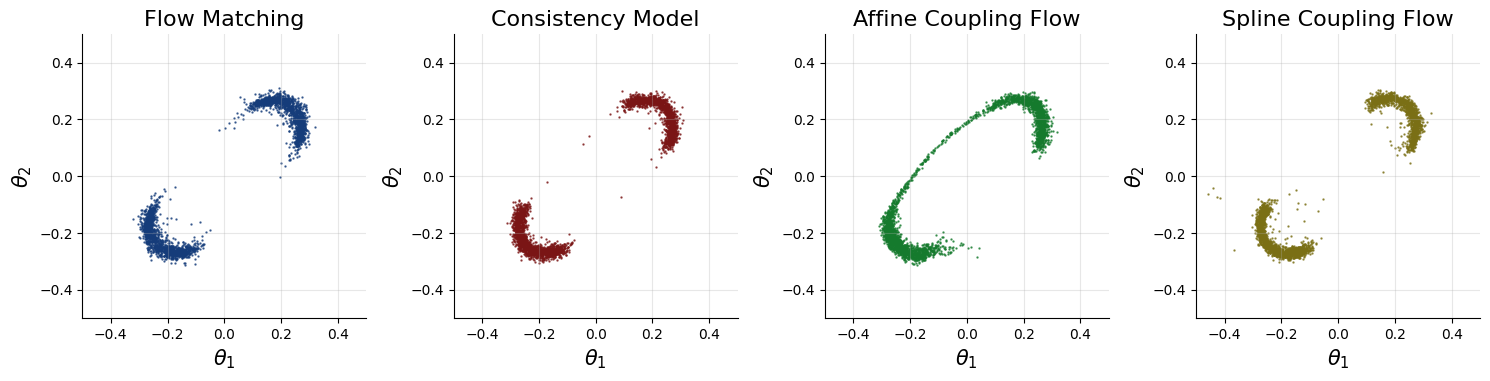

In [27]:
# Set the number of posterior draws you want to get
num_samples = 3000

# Obtain samples from amortized posterior
conditions = {"x": np.array([[0.0, 0.0]]).astype("float32")}

# Prepare figure
f, axes = plt.subplots(1, 4, figsize=(15, 6))

# Obtain samples from the approximators (can also use the workflows' methods)
nets = [
    flow_matching_workflow.approximator, 
    consistency_model_workflow.approximator,
    affine_flow_workflow.approximator,
    spline_flow_workflow.approximator
]
names = ["Flow Matching", "Consistency Model", "Affine Coupling Flow", "Spline Coupling Flow"]
colors = ["#153c7a", "#7a1515", "#157a2d", "#7a6f15"]

for ax, net, name, color in zip(axes, nets, names, colors):

    # Obtain samples
    samples = net.sample(conditions=conditions, num_samples=num_samples)["theta"]

    # Plot samples
    ax.scatter(samples[0, :, 0], samples[0, :, 1], color=color, alpha=0.75, s=0.5)
    sns.despine(ax=ax)
    ax.set_title(f"{name}", fontsize=16)
    ax.grid(alpha=0.3)
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlim([-0.5, 0.5])
    ax.set_ylim([-0.5, 0.5])
    ax.set_xlabel(r"$\theta_1$", fontsize=15)
    ax.set_ylabel(r"$\theta_2$", fontsize=15)

f.tight_layout()

The posterior looks as we have expected in this case. However, in general, we do not know how the posterior is supposed to look like for any specific dataset. As such, we need diagnostics that validate the correctness of the inferred posterior. One such diagnostic is simulation-based calibration(SBC), which we can apply for free due to amortization. For more details on SBC and diagnostic plots, see:

1. Talts, S., Betancourt, M., Simpson, D., Vehtari, A., & Gelman, A. (2018). Validating Bayesian inference algorithms with simulation-based calibration. *arXiv preprint*.
2. Säilynoja, T., Bürkner, P. C., & Vehtari, A. (2022). Graphical test for discrete uniformity and its applications in goodness-of-fit evaluation and multiple sample comparison. *Statistics and Computing*.
3. The practical SBC interpretation guide by Martin Modrák: https://hyunjimoon.github.io/SBC/articles/rank_visualizations.html

Check out the next tutorial for a detailed walkthrough of the workflow's functionality.